In [0]:
# Basic imports.
import os
import numpy as np
import torch
import time
import random
from tqdm import tqdm

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn
from torch.autograd import Variable

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'n_classes': 10,      # Number of classes.
    'lr': 1e-3,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 30,     # Mini-batch size.
    'visibility': 0.65
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


In [3]:
root = './'

# Setting dataloader.
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(root,
                             train=True,
                             download=True,
                             transform=data_transform)
test_set = datasets.MNIST(root,
                            train=False,
                            download=False,
                            transform=data_transform)

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=True)

print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Size of training set: 60000 samples
Size of test set: 10000 samples


# Atividade Prática

## Pixel RNN

Também é possível trabalhar de forma auto-supervisionada usando modelos recorrentes. Um exemplo de destaque é a PixelRNN, que considera cada pixel da imagem como uma unidade de sequência, e propõe um modelo probabilístico para prever o próximo pixel, dada uma sequência de pixels antecessores. A imagem a seguir ilustra essa proposta.
* Paper: https://arxiv.org/abs/1601.06759

<img src="https://drive.google.com/uc?export=view&id=198yw7kilta27G_bx3Ldcjguor_-qkk97" width="250"><br><br>

A melhor configuração dentre as propostas no artigo foi capaz de preencher lacunas em imagens com oclusões artificiais. Note que é preciso alimentar o modelo com uma porção significativa da imagem para que ele seja capaz de prever o restante.

<img src="https://miro.medium.com/max/700/0*o7PUa9K5rPGeFIcx." width="600"><br><br>



Uma modelagem simples para esse problema, se parece com o que aprendemos na aula de geração de sequências (seq2seq), porém não existe a etapa de codificação, apenas a decodificação do valor seguinte a partir do valor atual.

* Entrada: vetor linearizado e com a oclusão artificial ```(batch_size, 784, 1)```. A oclusão ocorre através do preenchimento com zeros em uma região fixa da imagem. O parâmetro ```args['visibility']``` determina o percentual da imagem visível para a rede.
* Saída esperada: dígito reconstruído extrapolando a oclusão. Para isso, o cálculo da loss é realizado comparando a reconstrução com o dado **original**. ```(batch_size, 784, 1)```


![](https://drive.google.com/uc?export=view&id=1DzHtZXT1dsWm4s7xbZfmu0NiLmKw7jpL)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(Seq2Seq, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.gru = nn.GRU(self.input_size, self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.activation = nn.Sigmoid()

    def forward(self, targets):

        hidden = torch.zeros(self.num_layers, targets.size(0), self.hidden_size).to(args['device'])
              
        output_rnn, hidden = self.gru(targets, hidden)
        output = output_rnn.contiguous().view(output_rnn.size(0)*output_rnn.size(1), output_rnn.size(2))
        output = self.activation(self.out(output))
        output = output.view(output_rnn.size(0), output_rnn.size(1), -1)
        
        return output
      

input_size  = 1
hidden_size = 128
output_size = 1 

pixelrnn = Seq2Seq(input_size, hidden_size, output_size).to(args['device'])


In [0]:
optimizer = optim.Adam(pixelrnn.parameters(),
                       lr=args['lr'],
                       betas=(args['momentum'], 0.999),
                       weight_decay=args['weight_decay'])

criterion = nn.MSELoss().to(args['device'])

In [0]:
def train(train_loader, net, criterion, optimizer, epoch):

    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    begin = time.time()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):
        if i > 501: break  

        # Obtaining images, labels and paths for batch.
        inps, _ = batch_data
        labs = inps.view(inps.size(0),-1).unsqueeze(-1)
        
        
        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])
        
        patch_occ = int(args['visibility'] * 784) 
        input_occ = torch.zeros(labs.size()).to(args['device'])
        input_occ[:,:patch_occ] = labs[:, :patch_occ]

        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs = net(input_occ[:,:-1])

        # Computing loss.
        loss = 0.
        for k, out in enumerate(outs):
          loss += criterion(out, labs[k, 1:])
        
        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Plot prediction
        prds = np.append(np.zeros( (len(outs),1,1) ), outs.detach().data.cpu().numpy(), axis=1)
        if i % 250 == 1:
          print(loss)
          fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
          
          img_label = labs[0].detach().data.cpu().numpy().reshape(inps.size(2), inps.size(3))
          axs[0].imshow(img_label, cmap='Greys')
          axs[0].set_title('Train - Ground Truth')
          
          img_label = input_occ[0].detach().data.cpu().numpy().reshape(inps.size(2), inps.size(3))
          axs[1].imshow(img_label, cmap='Greys')
          axs[1].set_title('Train - Input (Occlusion)')
          
          img = prds.reshape(inps.size(0), inps.size(2), inps.size(3))[0]
          axs[2].imshow(img, cmap='Greys')
          axs[2].set_title('Train - Prediction')
          
          plt.show()
          plt.close(fig)
          
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    end = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f | Time: %.2f ]' % (
        epoch, train_loss.mean(), train_loss.std(), end-begin))
    print('--------------------------------------------------------------------')
        
    return train_loss.mean(), end-begin
    
    
def test(test_loader, net, criterion, epoch):

    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    prd_list = []
    lab_list = []
    
    begin = time.time()
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):
        if i > 401: break

        # Obtaining images, labels and paths for batch.
        inps, _ = batch_data
        labs = inps.view(inps.size(0),-1).unsqueeze(-1)

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])
        
        patch_occ = int(args['visibility'] * 784) 
        input_occ = torch.zeros(labs.size()).to(args['device'])
        input_occ[:,:patch_occ] = labs[:, :patch_occ]

        # Forwarding.
        outs = net(input_occ[:, :-1])

        # Plot prediction
        prds = np.append(np.zeros( (len(outs),1,1) ), outs.detach().data.cpu().numpy(), axis=1)
        if i % 250 == 1:
          print(loss)
          fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
          
          img_label = labs[0].detach().data.cpu().numpy().reshape(inps.size(2), inps.size(3))
          axs[0].imshow(img_label, cmap='Greys')
          axs[0].set_title('Test - Ground Truth')
          
          img_label = input_occ[0].detach().data.cpu().numpy().reshape(inps.size(2), inps.size(3))
          axs[1].imshow(img_label, cmap='Greys')
          axs[1].set_title('Test - Input (Occlusion)')
          
          img = prds.reshape(inps.size(0), inps.size(2), inps.size(3))[0]
          axs[2].imshow(img, cmap='Greys')
          axs[2].set_title('Test - Prediction')
          
          plt.show()
          plt.close(fig)
        
        # Computing loss.
        loss = 0.
        for k, out in enumerate(outs):
          loss += criterion(out, labs[k, 1:])
        
        # Obtaining predictions.
        prds = outs.data.max(dim=1)[1].cpu().numpy()
        
        # Updating lists.
        test_loss.append(loss.data.item())
        prd_list.append(prds)
        lab_list.append(labs.detach().cpu().numpy())
        
    end = time.time()
    
    # Computing accuracy.
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f | Time: %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), end-begin))
    print('--------------------------------------------------------------------')
    
    return test_loss.mean(), end-begin

tensor(6.2940, device='cuda:0', grad_fn=<AddBackward0>)


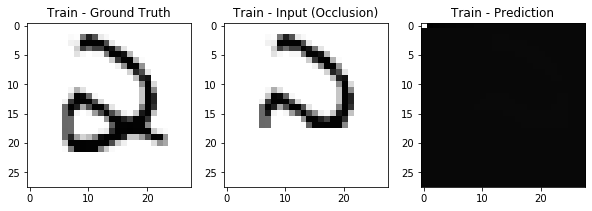

tensor(1.3757, device='cuda:0', grad_fn=<AddBackward0>)


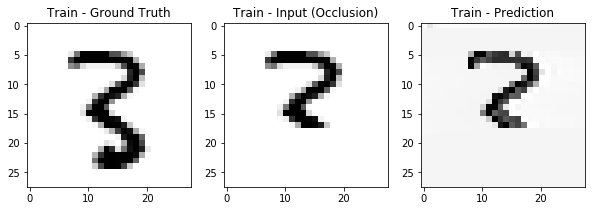

tensor(1.3224, device='cuda:0', grad_fn=<AddBackward0>)


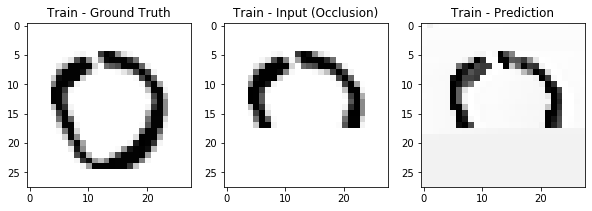

--------------------------------------------------------------------
[epoch 1], [train loss 1.6473 +/- 0.6691 | Time: 29.22 ]
--------------------------------------------------------------------
tensor(1.2766, device='cuda:0', grad_fn=<AddBackward0>)


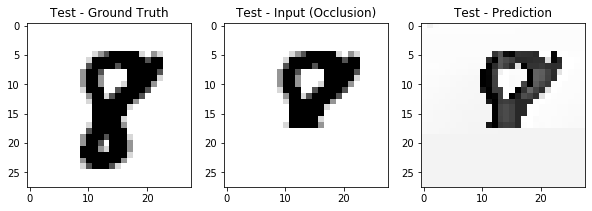

tensor(1.2783, device='cuda:0', grad_fn=<AddBackward0>)


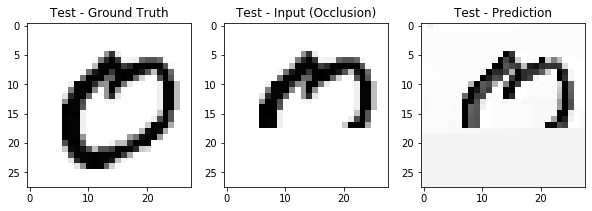

--------------------------------------------------------------------
[epoch 1], [test loss 1.3315 +/- 0.0907 | Time: 10.74]
--------------------------------------------------------------------
tensor(1.2442, device='cuda:0', grad_fn=<AddBackward0>)


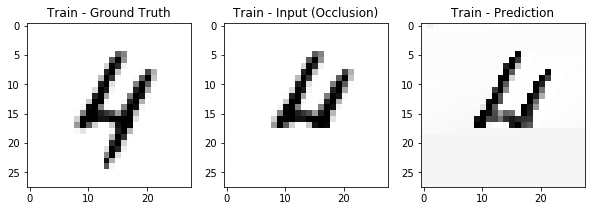

tensor(1.2143, device='cuda:0', grad_fn=<AddBackward0>)


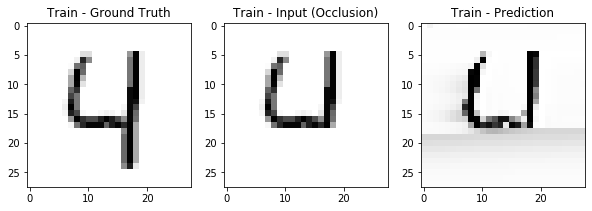

tensor(1.0393, device='cuda:0', grad_fn=<AddBackward0>)


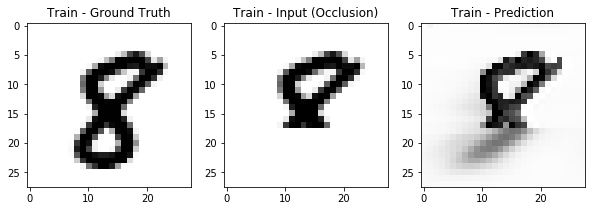

--------------------------------------------------------------------
[epoch 2], [train loss 1.2003 +/- 0.1222 | Time: 29.33 ]
--------------------------------------------------------------------
tensor(0.9034, device='cuda:0', grad_fn=<AddBackward0>)


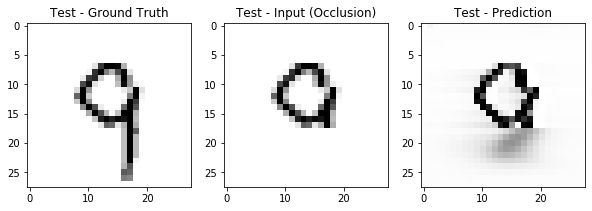

tensor(1.0509, device='cuda:0', grad_fn=<AddBackward0>)


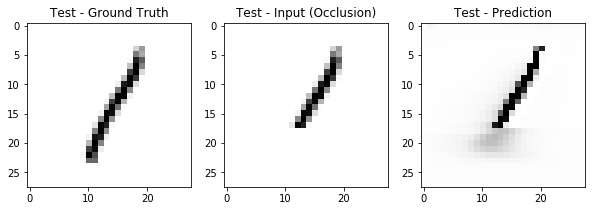

--------------------------------------------------------------------
[epoch 2], [test loss 0.9408 +/- 0.0591 | Time: 10.78]
--------------------------------------------------------------------
tensor(0.9179, device='cuda:0', grad_fn=<AddBackward0>)


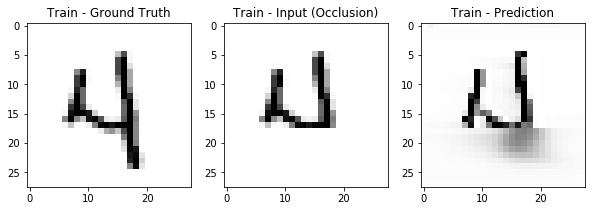

tensor(0.9820, device='cuda:0', grad_fn=<AddBackward0>)


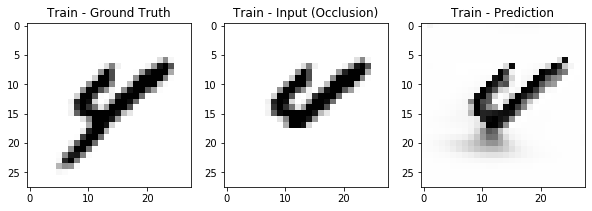

tensor(0.7964, device='cuda:0', grad_fn=<AddBackward0>)


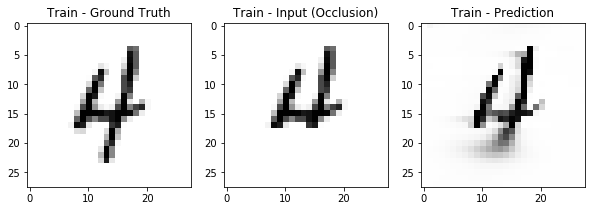

--------------------------------------------------------------------
[epoch 3], [train loss 0.8844 +/- 0.0720 | Time: 29.56 ]
--------------------------------------------------------------------
tensor(0.9630, device='cuda:0', grad_fn=<AddBackward0>)


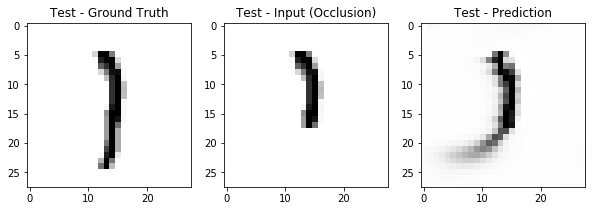

In [0]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

#     Training function.
    train(train_loader, pixelrnn, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, pixelrnn, criterion, epoch)